## Human in Loop

For human-in-the-loop, we often want to see our graph outputs as its running.

## 1. Breakpoints for human approval

Let's assume that are concerned about tool use: we want to approve the agent to use any of its tools.

In [1]:
import getpass
import os

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-001",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

In [3]:
# create tools and bind tools to the llm
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
# bind the tools to llm
llm_with_tools = llm.bind_tools(tools)

In [ ]:
# build the graph with break point before executing the tools
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# system message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# graph
builder = StateGraph(MessagesState)

# define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["tools"], checkpointer=memory)

In [ ]:
# import nest_asyncio
# from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
# nest_asyncio.apply() # required for jupyter notebook to run async functions

# display(Image(
# graph.get_graph().draw_mermaid_png(
# curve_style=CurveStyle.BASIS,
# node_colors=NodeStyles(first="#64784", last="#baffc9", default="#fad7de"),
# output_file_path="./graph.png",
# draw_method=MermaidDrawMethod.PYPPETEER,
# background_color="white",
# padding=1,)))

In [10]:
# sample run with the interrupt
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (a8f472b9-4871-46c5-adf9-40007daebd06)
 Call ID: a8f472b9-4871-46c5-adf9-40007daebd06
  Args:
    a: 2.0
    b: 3.0


In [11]:
# now we will see what is the next node to be executed after the interrupt
state = graph.get_state(thread)
state.next

('tools',)

In [13]:
# if we invoke the node with none it start from executing from the last node it interrupted 
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


In [15]:
# simple user approval for the graph execution 
# Input
initial_input = {"messages": HumanMessage(content="Multiply 24 and 28")}

# Thread
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

# Get user feedback
user_approval = input("Do you want to call the tool? (yes/no): ")
print(f"User: {user_approval}")

# Check approval
if user_approval.lower() == "yes":
    
    # If approved, continue the graph execution
    for event in graph.stream(None, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()
        
else:
    print("Operation cancelled by user.")

================================ Human Message =================================

Multiply 24 and 28
================================== Ai Message ==================================
Tool Calls:
  multiply (4c3d20db-f4e6-4592-8c24-e3097add9ab0)
 Call ID: 4c3d20db-f4e6-4592-8c24-e3097add9ab0
  Args:
    a: 24.0
    b: 28.0
User: yes
================================== Ai Message ==================================
Tool Calls:
  multiply (4c3d20db-f4e6-4592-8c24-e3097add9ab0)
 Call ID: 4c3d20db-f4e6-4592-8c24-e3097add9ab0
  Args:
    a: 24.0
    b: 28.0
================================= Tool Message =================================
Name: multiply

672
================================== Ai Message ==================================

The result of multiplying 24 and 28 is 672.


## 2. Editing graph state
Now, let's show how to directly edit the graph state and insert human feedback.

But breakpoints are also opportunities to modify the graph state.

Let's set up our agent with a breakpoint before the assistant node.

In [3]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]

# bind the tools to llm
llm_with_tools = llm.bind_tools(tools)

In [4]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

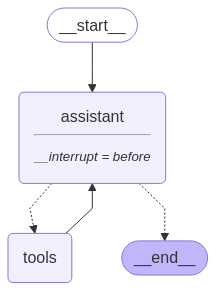

In [5]:
# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [6]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [ ]:
state = graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='507feeb2-7816-487d-9f09-a312f24f1332'), HumanMessage(content='No, actually multiply 3 and 3!', additional_kwargs={}, response_metadata={}, id='75a4407c-bbba-4561-a47c-07e4066b5163')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0237f2-02ec-6874-8001-af82ee1456a5'}}, metadata={'source': 'update', 'writes': {'__start__': {'messages': [HumanMessage(content='No, actually multiply 3 and 3!', additional_kwargs={}, response_metadata={}, id='75a4407c-bbba-4561-a47c-07e4066b5163')]}}, 'step': 1, 'parents': {}, 'thread_id': '1'}, created_at='2025-04-27T15:48:55.624101+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0237de-ba3a-6842-8000-c08af7be09cb'}}, tasks=(PregelTask(id='a015b010-4916-9f31-d3d1-8b7a147a870e', name='assistant', path=('__pregel_pull', 'assistan

In [8]:
graph.update_state(
    thread,
    {"messages": [HumanMessage(content="No, actually multiply 3 and 3!")]},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0237f2-02ec-6874-8001-af82ee1456a5'}}

In [9]:
new_state = graph.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

No, actually multiply 3 and 3!


In [11]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, actually multiply 3 and 3!
================================== Ai Message ==================================
Tool Calls:
  multiply (4e89dd3a-1db2-4a71-9f14-b24fe5f1bba7)
 Call ID: 4e89dd3a-1db2-4a71-9f14-b24fe5f1bba7
  Args:
    a: 3.0
    b: 3.0
================================= Tool Message =================================
Name: multiply

9


In [12]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

9
================================== Ai Message ==================================

OK. The answer is 9.
